# TabPFN增强版：性早熟预测模型

**使用TabPFN-Extensions进行全方位优化**

本笔记本展示了TabPFN的多种增强技术：
- 基础TabPFN模型
- 超参数优化（HPO）
- Post-hoc集成（AutoTabPFN）
- SHAP可解释性分析
- 特征选择优化
- 改进的采样策略

## 1. 导入必要的库

In [1]:
# 设置环境变量
import os

os.environ["SCIPY_ARRAY_API"] = "1"

import pandas as pd
import numpy as np
import warnings
import joblib

warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
    confusion_matrix,
)
from sklearn.impute import SimpleImputer

# TabPFN相关库
from tabpfn import TabPFNClassifier
from tabpfn_extensions.hpo import TunedTabPFNClassifier
from tabpfn_extensions.post_hoc_ensembles.sklearn_interface import AutoTabPFNClassifier
from tabpfn_extensions import interpretability
from tabpfn_extensions.embedding import TabPFNEmbedding

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False

print("所有库导入完成")

所有库导入完成


## 2. 设置路径和参数

In [2]:
os.makedirs("./output", exist_ok=True)
os.makedirs("./output/models", exist_ok=True)
os.makedirs("./output/enhanced", exist_ok=True)

RANDOM_SEED = 825
np.random.seed(RANDOM_SEED)
N_JOBS = -1

print(f"随机种子设置: {RANDOM_SEED}")
print(f"输出目录: ./output/enhanced/")

随机种子设置: 825
输出目录: ./output/enhanced/


## 3. 读取数据

In [3]:
normal_data = pd.read_csv("./input/性早熟数据激发试验正常组_new.csv")
disease_data = pd.read_csv("./input/激发试验确诊性早熟组数据_new.csv")

normal_data["group"] = "N"
disease_data["group"] = "Y"

print(f"正常组: {normal_data.shape[0]} 行, 早熟组: {disease_data.shape[0]} 行")

正常组: 8970 行, 早熟组: 10654 行


## 4. 数据类型处理和合并

In [4]:
data = pd.concat([normal_data, disease_data], axis=0, ignore_index=True)
data["group"] = data["group"].astype("category")
print(f"合并后数据: {data.shape[0]} 行 x {data.shape[1]} 列")
print(f"分组统计:\n{data['group'].value_counts()}")

合并后数据: 19624 行 x 40 列
分组统计:
group
Y    10654
N     8970
Name: count, dtype: int64


## 5. 划分训练集和验证集

In [5]:
train_data, validation_data = train_test_split(
    data, test_size=0.3, stratify=data["group"], random_state=RANDOM_SEED
)

print(f"训练集: {train_data.shape[0]} 行, 验证集: {validation_data.shape[0]} 行")

训练集: 13736 行, 验证集: 5888 行


## 6. 特征工程

In [6]:
exclude_cols = ["group", "患者编号", "Unnamed: 0"]
feature_cols = [col for col in train_data.columns if col not in exclude_cols]

X_train = train_data[feature_cols].copy()
y_train = train_data["group"].copy()
X_validation = validation_data[feature_cols].copy()
y_validation = validation_data["group"].copy()

y_train_binary = (y_train == "Y").astype(int)
y_validation_binary = (y_validation == "Y").astype(int)

print(f"使用 {len(feature_cols)} 个特征")
print(f"训练集正负样本: {y_train_binary.value_counts().to_dict()}")
print(f"验证集正负样本: {y_validation_binary.value_counts().to_dict()}")

使用 38 个特征
训练集正负样本: {1: 7457, 0: 6279}
验证集正负样本: {1: 3197, 0: 2691}


## 7. 数据类型转换

In [7]:
print("数据类型转换中...")

for col in feature_cols:
    X_train[col] = pd.to_numeric(X_train[col], errors="coerce")
    X_validation[col] = pd.to_numeric(X_validation[col], errors="coerce")

print(f"转换完成 - 训练集: {X_train.dtypes.value_counts().to_dict()}")

数据类型转换中...
转换完成 - 训练集: {dtype('float64'): 38}


## 8. 数据预处理（缺失值填充）

In [8]:
print("数据预处理开始...")

# 使用中位数填充缺失值
imputer = SimpleImputer(strategy="median")

X_train_processed = imputer.fit_transform(X_train)
X_validation_processed = imputer.transform(X_validation)

# 移除全为NaN的特征
valid_features = ~np.isnan(X_train_processed).all(axis=0)
X_train_processed = X_train_processed[:, valid_features]
X_validation_processed = X_validation_processed[:, valid_features]

# 更新特征列表
feature_cols_processed = [
    col for col, valid in zip(feature_cols, valid_features) if valid
]

print(f"预处理完成！")
print(f"  原始特征数: {X_train.shape[1]}")
print(f"  处理后特征数: {X_train_processed.shape[1]}")
print(f"  训练集样本: {X_train_processed.shape[0]}")
print(f"  验证集样本: {X_validation_processed.shape[0]}")
print(f"  缺失值: {np.isnan(X_train_processed).sum()} (应为0)")

数据预处理开始...
预处理完成！
  原始特征数: 38
  处理后特征数: 38
  训练集样本: 13736
  验证集样本: 5888
  缺失值: 0 (应为0)


---
# 模型训练与优化

## 9. 准备训练数据（分层采样）

In [9]:
# 由于TabPFN限制，采用分层采样保持类别平衡
max_samples = 10000

if len(X_train_processed) > max_samples:
    print(f"训练集样本数({len(X_train_processed)})超过{max_samples}，进行分层采样")

    # 使用分层采样保持类别平衡
    sss = StratifiedShuffleSplit(
        n_splits=1, train_size=max_samples, random_state=RANDOM_SEED
    )
    for sample_idx, _ in sss.split(X_train_processed, y_train_binary):
        X_train_sampled = X_train_processed[sample_idx]
        y_train_sampled = y_train_binary.iloc[sample_idx].values

    print(f"采样后类别分布: {np.bincount(y_train_sampled)}")
else:
    X_train_sampled = X_train_processed
    y_train_sampled = y_train_binary.values

print(f"训练样本: {len(X_train_sampled)}, 特征数: {X_train_sampled.shape[1]}")

训练集样本数(13736)超过10000，进行分层采样
采样后类别分布: [4571 5429]
训练样本: 10000, 特征数: 38


## 10. 模型1：基础TabPFN

In [11]:
print("=" * 70)
print("训练基础TabPFN模型")
print("=" * 70)

# 基础TabPFN模型
tabpfn_basic = TabPFNClassifier(
    n_estimators=32,
    device="cuda",
    random_state=RANDOM_SEED,
)

print("开始训练...")
tabpfn_basic.fit(X_train_sampled, y_train_sampled)

y_pred_basic = tabpfn_basic.predict(X_validation_processed)
y_pred_proba_basic = tabpfn_basic.predict_proba(X_validation_processed)[:, 1]

auc_basic = roc_auc_score(y_validation_binary, y_pred_proba_basic)
f1_basic = f1_score(y_validation_binary, y_pred_basic)
acc_basic = accuracy_score(y_validation_binary, y_pred_basic)

print(f"\n基础TabPFN性能:")
print(f"  AUC: {auc_basic:.4f}")
print(f"  F1:  {f1_basic:.4f}")
print(f"  ACC: {acc_basic:.4f}")

# 保存模型
joblib.dump(
    {"model": tabpfn_basic, "imputer": imputer},
    "./output/enhanced/models/tabpfn_basic.pkl",
)
print(f"\n模型已保存: ./output/enhanced/models/tabpfn_basic.pkl")
# 基础TabPFN性能（器官平均）:
#   AUC: 0.9633
#   F1:  0.9068
#   ACC: 0.8947

训练基础TabPFN模型
开始训练...

基础TabPFN性能:
  AUC: 0.9633
  F1:  0.9068
  ACC: 0.8947

模型已保存: ./output/enhanced/models/tabpfn_basic.pkl


## 11. 模型2：超参数优化（HPO）

使用TunedTabPFNClassifier自动搜索最优超参数

In [ ]:
print("=" * 70)
print("训练HPO优化TabPFN模型")
print("=" * 70)

# 超参数优化
tabpfn_hpo = TunedTabPFNClassifier(
    n_trials=700,
    metric="f1",  # 优化目标：F1分数
    # metric='roc_auc',       # 优化目标：AUC分数
    device="cuda",
    random_state=RANDOM_SEED,
    verbose=True,
)

print("开始超参数搜索...")
tabpfn_hpo.fit(X_train_sampled, y_train_sampled)

y_pred_hpo = tabpfn_hpo.predict(X_validation_processed)
y_pred_proba_hpo = tabpfn_hpo.predict_proba(X_validation_processed)[:, 1]

auc_hpo = roc_auc_score(y_validation_binary, y_pred_proba_hpo)
f1_hpo = f1_score(y_validation_binary, y_pred_hpo)
acc_hpo = accuracy_score(y_validation_binary, y_pred_hpo)

print(f"\nHPO优化TabPFN性能:")
print(f"  AUC: {auc_hpo:.4f} (vs 基础: {auc_hpo - auc_basic:+.4f})")
print(f"  F1:  {f1_hpo:.4f} (vs 基础: {f1_hpo - f1_basic:+.4f})")
print(f"  ACC: {acc_hpo:.4f} (vs 基础: {acc_hpo - acc_basic:+.4f})")

# 保存模型
joblib.dump(
    {"model": tabpfn_hpo, "imputer": imputer},
    "./output/enhanced/models/tabpfn_hpo.pkl",
)
print(f"\n模型已保存: ./output/enhanced/models/tabpfn_hpo.pkl")

## 12. 模型3：Post-hoc集成（AutoTabPFN）

自动训练和集成多个TabPFN配置

In [13]:
print("=" * 70)
print("训练Post-hoc集成TabPFN模型")
print("=" * 70)

# 检查GPU状态
import torch

print(f"PyTorch CUDA 可用: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU 设备: {torch.cuda.get_device_name(0)}")
    print(f"CUDA 设备数量: {torch.cuda.device_count()}")
else:
    raise RuntimeError("CUDA 不可用，无法继续")

# 检查Ray版本（确保使用了降级后的版本）
import ray

print(f"Ray 版本: {ray.__version__}")

# Post-hoc集成
tabpfn_auto = AutoTabPFNClassifier(
    max_time=12600,
    presets="best_quality",
    device="cuda:0",
)

print("模型初始化成功")
print("使用设备: cuda:0")
print("开始自动集成训练...")
print("(这可能需要较长时间，正在训练多个模型配置...)")

tabpfn_auto.fit(X_train_sampled, y_train_sampled)

y_pred_auto = tabpfn_auto.predict(X_validation_processed)
y_pred_proba_auto = tabpfn_auto.predict_proba(X_validation_processed)[:, 1]

auc_auto = roc_auc_score(y_validation_binary, y_pred_proba_auto)
f1_auto = f1_score(y_validation_binary, y_pred_auto)
acc_auto = accuracy_score(y_validation_binary, y_pred_auto)

print(f"\nPost-hoc集成TabPFN性能:")
print(f"  AUC: {auc_auto:.4f} (vs 基础: {auc_auto - auc_basic:+.4f})")
print(f"  F1:  {f1_auto:.4f} (vs 基础: {f1_auto - f1_basic:+.4f})")
print(f"  ACC: {acc_auto:.4f} (vs 基础: {acc_auto - acc_basic:+.4f})")

# 保存模型
joblib.dump(
    {"model": tabpfn_auto, "imputer": imputer},
    "./output/enhanced/models/tabpfn_auto.pkl",
)
print(f"\n模型已保存: ./output/enhanced/models/tabpfn_auto.pkl")

训练Post-hoc集成TabPFN模型
PyTorch CUDA 可用: True
GPU 设备: NVIDIA GeForce RTX 3080 Laptop GPU
CUDA 设备数量: 1
Ray 版本: 2.6.0
模型初始化成功
使用设备: cuda:0
开始自动集成训练...
(这可能需要较长时间，正在训练多个模型配置...)


config.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]


Post-hoc集成TabPFN性能:
  AUC: 0.9673 (vs 基础: +0.0040)
  F1:  0.9112 (vs 基础: +0.0044)
  ACC: 0.9003 (vs 基础: +0.0056)

模型已保存: ./output/enhanced/models/tabpfn_auto.pkl


## 13. 无监督学习：异常检测（Unsupervised）

使用TabPFN进行异常样本检测

TabPFN嵌入提取分析
提取TabPFN内部嵌入表示...

提取训练集嵌入...
提取验证集嵌入...
嵌入维度: (10000, 192)

基于TabPFN嵌入的逻辑回归性能:
  AUC: 0.9605
  F1:  0.8605
  ACC: 0.8244


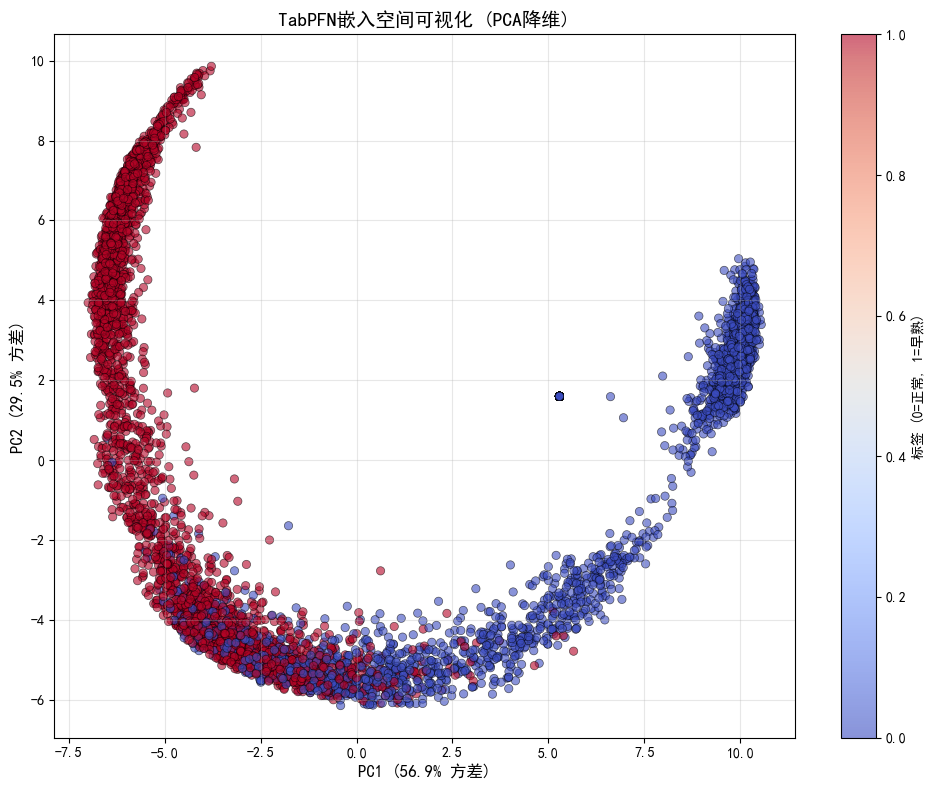


嵌入空间可视化已保存
嵌入数据已保存


In [14]:
print("=" * 70)
print("TabPFN嵌入提取分析")
print("=" * 70)

print("提取TabPFN内部嵌入表示...\n")

# 使用已训练的基础TabPFN模型作为嵌入提取器
embedding_extractor = TabPFNEmbedding(tabpfn_clf=tabpfn_basic, n_fold=0)

# 提取训练集嵌入
print("提取训练集嵌入...")
train_embeddings = embedding_extractor.get_embeddings(
    X_train_sampled, y_train_sampled, X_train_sampled, data_source="train"
)

# 提取验证集嵌入
print("提取验证集嵌入...")
val_embeddings = embedding_extractor.get_embeddings(
    X_train_sampled, y_train_sampled, X_validation_processed, data_source="test"
)

print(f"嵌入维度: {train_embeddings[0].shape}")

# 使用嵌入训练逻辑回归
from sklearn.linear_model import LogisticRegression

embedding_model = LogisticRegression(max_iter=1000, random_state=RANDOM_SEED)
embedding_model.fit(train_embeddings[0], y_train_sampled)

y_pred_embedding = embedding_model.predict(val_embeddings[0])
y_pred_proba_embedding = embedding_model.predict_proba(val_embeddings[0])[:, 1]

auc_embedding = roc_auc_score(y_validation_binary, y_pred_proba_embedding)
f1_embedding = f1_score(y_validation_binary, y_pred_embedding)
acc_embedding = accuracy_score(y_validation_binary, y_pred_embedding)

print(f"\n基于TabPFN嵌入的逻辑回归性能:")
print(f"  AUC: {auc_embedding:.4f}")
print(f"  F1:  {f1_embedding:.4f}")
print(f"  ACC: {acc_embedding:.4f}")

# 可视化嵌入空间（使用PCA降维）
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
val_embeddings_2d = pca.fit_transform(val_embeddings[0])

plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    val_embeddings_2d[:, 0],
    val_embeddings_2d[:, 1],
    c=y_validation_binary,
    cmap="coolwarm",
    alpha=0.6,
    edgecolors="k",
    linewidth=0.5,
)
plt.colorbar(scatter, label="标签 (0=正常, 1=早熟)")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%} 方差)", fontsize=12)
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%} 方差)", fontsize=12)
plt.title("TabPFN嵌入空间可视化 (PCA降维)", fontsize=14, fontweight="bold")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("./output/enhanced/TabPFN嵌入可视化.png", dpi=300, bbox_inches="tight")
plt.savefig("./output/enhanced/TabPFN嵌入可视化.pdf", dpi=300, bbox_inches="tight")
plt.show()

print(f"\n嵌入空间可视化已保存")

# 保存嵌入
np.save("./output/enhanced/train_embeddings.npy", train_embeddings[0])
np.save("./output/enhanced/val_embeddings.npy", val_embeddings[0])
print("嵌入数据已保存")
# 验证集两类样本在嵌入空间中有较好的分离度，说明TabPFN模型学到了有效的特征表示

### *导入模型文件

In [11]:
print("=" * 70)
print("导入已训练的模型并计算性能")
print("=" * 70)

import os
import joblib

# 模型文件路径
model_files = {
    "基础TabPFN": "./output/enhanced/models/tabpfn_basic.pkl",
    "HPO优化TabPFN": "./output/enhanced/models/tabpfn_hpo.pkl",
    "Post-hoc集成TabPFN": "./output/enhanced/models/tabpfn_auto.pkl",
}

# 导入模型
loaded_models = {}
for model_name, file_path in model_files.items():
    if os.path.exists(file_path):
        loaded_models[model_name] = joblib.load(file_path)

print(f"成功导入 {len(loaded_models)} 个模型")

# 计算性能
if loaded_models:
    # 提取模型
    tabpfn_basic = loaded_models["基础TabPFN"]["model"]
    tabpfn_hpo = loaded_models["HPO优化TabPFN"]["model"]
    tabpfn_auto = loaded_models["Post-hoc集成TabPFN"]["model"]
    imputer = loaded_models["基础TabPFN"]["imputer"]

    # 基础TabPFN
    y_pred_basic = tabpfn_basic.predict(X_validation_processed)
    y_pred_proba_basic = tabpfn_basic.predict_proba(X_validation_processed)[:, 1]
    auc_basic = roc_auc_score(y_validation_binary, y_pred_proba_basic)
    f1_basic = f1_score(y_validation_binary, y_pred_basic)
    acc_basic = accuracy_score(y_validation_binary, y_pred_basic)

    # HPO优化TabPFN
    y_pred_hpo = tabpfn_hpo.predict(X_validation_processed)
    y_pred_proba_hpo = tabpfn_hpo.predict_proba(X_validation_processed)[:, 1]
    auc_hpo = roc_auc_score(y_validation_binary, y_pred_proba_hpo)
    f1_hpo = f1_score(y_validation_binary, y_pred_hpo)
    acc_hpo = accuracy_score(y_validation_binary, y_pred_hpo)

    # Post-hoc集成TabPFN
    y_pred_auto = tabpfn_auto.predict(X_validation_processed)
    y_pred_proba_auto = tabpfn_auto.predict_proba(X_validation_processed)[:, 1]
    auc_auto = roc_auc_score(y_validation_binary, y_pred_proba_auto)
    f1_auto = f1_score(y_validation_binary, y_pred_auto)
    acc_auto = accuracy_score(y_validation_binary, y_pred_auto)

    # 打印性能对比
    print("\n模型性能对比：")
    print(
        f"  基础TabPFN:      F1={f1_basic:.4f}  AUC={auc_basic:.4f}  ACC={acc_basic:.4f}"
    )
    print(
        f"  HPO优化:         F1={f1_hpo:.4f}  AUC={auc_hpo:.4f}  ACC={acc_hpo:.4f}  ({f1_hpo-f1_basic:+.4f})"
    )
    print(
        f"  Post-hoc集成:    F1={f1_auto:.4f}  AUC={auc_auto:.4f}  ACC={acc_auto:.4f}  ({f1_auto-f1_basic:+.4f})"
    )

    print("\n性能计算完成，变量已就绪")
else:
    print("\n未导入任何模型")

导入已训练的模型并计算性能
成功导入 3 个模型

模型性能对比：
  基础TabPFN:      F1=0.9068  AUC=0.9633  ACC=0.8947
  HPO优化:         F1=0.9087  AUC=0.9653  ACC=0.8972  (+0.0019)
  Post-hoc集成:    F1=0.9112  AUC=0.9673  ACC=0.9003  (+0.0044)

性能计算完成，变量已就绪


## 14.性能对比

In [12]:
# 创建性能对比表
models_list = [
    ("基础TabPFN", auc_basic, f1_basic, acc_basic),
    ("HPO优化TabPFN", auc_hpo, f1_hpo, acc_hpo),
    ("Post-hoc集成TabPFN", auc_auto, f1_auto, acc_auto),
]

performance_summary = pd.DataFrame(models_list, columns=["模型", "AUC", "F1", "准确率"])
# 按F1分数排序（从高到低）
performance_summary = performance_summary.sort_values("F1", ascending=False)

print("\n" + "=" * 70)
print("TabPFN模型性能对比（以F1分数为准）")
print("=" * 70)
print(performance_summary.to_string(index=False))
print("=" * 70)

best_model_name = performance_summary.iloc[0]["模型"]
best_f1 = performance_summary.iloc[0]["F1"]
best_auc = performance_summary.iloc[0]["AUC"]
f1_improvement = (best_f1 - f1_basic) * 100

print(f"\n最佳模型: {best_model_name}")
print(f"   F1:  {best_f1:.4f} (相比基础模型: {f1_improvement:+.2f}%)")
print(f"   AUC: {best_auc:.4f}")
print(f"   ACC: {performance_summary.iloc[0]['准确率']:.4f}")

# 保存性能对比
performance_summary.to_csv(
    "./output/enhanced/性能对比.csv", index=False, encoding="utf-8-sig"
)
print(f"\n性能对比已保存: ./output/enhanced/性能对比.csv")


TabPFN模型性能对比（以F1分数为准）
              模型      AUC       F1      准确率
Post-hoc集成TabPFN 0.967286 0.911182 0.900306
     HPO优化TabPFN 0.965288 0.908734 0.897249
        基础TabPFN 0.963269 0.906795 0.894701

最佳模型: Post-hoc集成TabPFN
   F1:  0.9112 (相比基础模型: +0.44%)
   AUC: 0.9673
   ACC: 0.9003

性能对比已保存: ./output/enhanced/性能对比.csv


## 15. ROC曲线

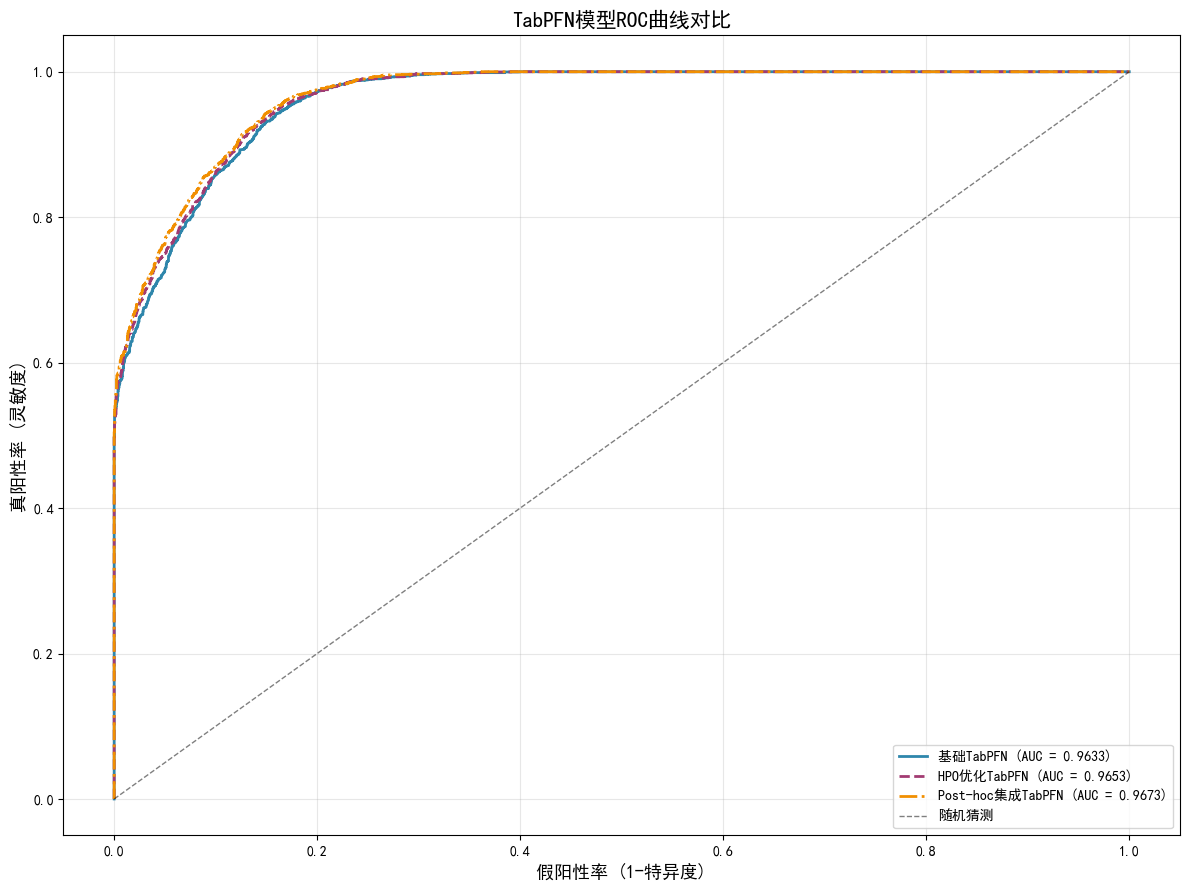

ROC曲线对比已保存


In [15]:
plt.figure(figsize=(12, 9))

# 基础TabPFN
fpr_basic, tpr_basic, _ = roc_curve(y_validation_binary, y_pred_proba_basic)
plt.plot(
    fpr_basic,
    tpr_basic,
    label=f"基础TabPFN (AUC = {auc_basic:.4f})",
    linewidth=2,
    color="#2E86AB",
    linestyle="-",
)

# HPO优化TabPFN
fpr_hpo, tpr_hpo, _ = roc_curve(y_validation_binary, y_pred_proba_hpo)
plt.plot(
    fpr_hpo,
    tpr_hpo,
    label=f"HPO优化TabPFN (AUC = {auc_hpo:.4f})",
    linewidth=2,
    color="#A23B72",
    linestyle="--",
)

# Post-hoc集成TabPFN
fpr_auto, tpr_auto, _ = roc_curve(y_validation_binary, y_pred_proba_auto)
plt.plot(
    fpr_auto,
    tpr_auto,
    label=f"Post-hoc集成TabPFN (AUC = {auc_auto:.4f})",
    linewidth=2,
    color="#F18F01",
    linestyle="-.",
)

# 随机猜测基线
plt.plot([0, 1], [0, 1], "k--", linewidth=1, label="随机猜测", alpha=0.5)

plt.xlabel("假阳性率 (1-特异度)", fontsize=13)
plt.ylabel("真阳性率 (灵敏度)", fontsize=13)
plt.title("TabPFN模型ROC曲线对比", fontsize=15, fontweight="bold")
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()

plt.savefig("./output/enhanced/ROC曲线对比.pdf", dpi=300, bbox_inches="tight")
plt.savefig("./output/enhanced/ROC曲线对比.png", dpi=300, bbox_inches="tight")
plt.show()

print("ROC曲线对比已保存")

## 16. 详细性能指标对比

In [ ]:
# 为所有模型计算详细指标
models_results = {
    "基础TabPFN": (y_pred_basic, y_pred_proba_basic),
    "HPO优化TabPFN": (y_pred_hpo, y_pred_proba_hpo),
    "Post-hoc集成TabPFN": (y_pred_auto, y_pred_proba_auto),
}

detailed_metrics = []

for model_name, (y_pred, y_pred_proba) in models_results.items():
    cm = confusion_matrix(y_validation_binary, y_pred)

    accuracy = accuracy_score(y_validation_binary, y_pred)
    precision = precision_score(y_validation_binary, y_pred)
    recall = recall_score(y_validation_binary, y_pred)
    f1 = f1_score(y_validation_binary, y_pred)
    auc = roc_auc_score(y_validation_binary, y_pred_proba)
    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])

    detailed_metrics.append(
        {
            "模型": model_name,
            "AUC": auc,
            "准确率": accuracy,
            "精确率": precision,
            "召回率": recall,
            "特异度": specificity,
            "F1分数": f1,
        }
    )

    print(f"\n{'='*70}")
    print(f"{model_name} 详细指标")
    print(f"{'='*70}")
    print(f"混淆矩阵:")
    print(cm)
    print(f"TN={cm[0,0]}, FP={cm[0,1]}, FN={cm[1,0]}, TP={cm[1,1]}")
    print(f"\n准确率: {accuracy:.4f}")
    print(f"精确率: {precision:.4f}")
    print(f"召回率: {recall:.4f}")
    print(f"特异度: {specificity:.4f}")
    print(f"F1分数: {f1:.4f}")
    print(f"AUC:    {auc:.4f}")

# 保存详细指标
detailed_df = pd.DataFrame(detailed_metrics)
detailed_df = detailed_df.sort_values("F1分数", ascending=False)
detailed_df.to_csv(
    "./output/enhanced/详细性能指标.csv", index=False, encoding="utf-8-sig"
)

print(f"\n\n{'='*70}")
print("所有模型详细指标汇总")
print(f"{'='*70}")
print(detailed_df.to_string(index=False))
print(f"\n详细性能指标已保存: ./output/enhanced/详细性能指标.csv")

## 17. 预测概率分布对比

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(14, 12))

models_plot = [
    ("基础TabPFN", y_pred_proba_basic),
    ("HPO优化TabPFN", y_pred_proba_hpo),
    ("Post-hoc集成TabPFN", y_pred_proba_auto),
]

for idx, (model_name, y_pred_proba) in enumerate(models_plot):
    # 概率分布直方图
    ax1 = axes[idx, 0]
    for label, name in [(0, "正常(N)"), (1, "早熟(Y)")]:
        mask = y_validation_binary == label
        ax1.hist(y_pred_proba[mask], bins=30, alpha=0.6, label=name)
    ax1.set_xlabel("预测概率", fontsize=11)
    ax1.set_ylabel("样本数量", fontsize=11)
    ax1.set_title(f"{model_name} - 预测概率分布", fontsize=12, fontweight="bold")
    ax1.legend()
    ax1.grid(alpha=0.3)

    # 概率箱线图
    ax2 = axes[idx, 1]
    data_plot = pd.DataFrame(
        {
            "概率": y_pred_proba,
            "真实标签": [
                "正常(N)" if y == 0 else "早熟(Y)" for y in y_validation_binary
            ],
        }
    )
    sns.boxplot(data=data_plot, x="真实标签", y="概率", ax=ax2)
    ax2.set_title(f"{model_name} - 预测概率箱线图", fontsize=12, fontweight="bold")
    ax2.grid(alpha=0.3, axis="y")

plt.tight_layout()
plt.savefig("./output/enhanced/预测概率分布对比.pdf", dpi=300, bbox_inches="tight")
plt.savefig("./output/enhanced/预测概率分布对比.png", dpi=300, bbox_inches="tight")
plt.show()

print("预测概率分布对比图已保存")

In [ ]:
# 保存所有模型的预测结果
predictions_dict = {
    "真实标签": y_validation_binary,
    "基础TabPFN_预测": y_pred_basic,
    "基础TabPFN_概率": y_pred_proba_basic,
    "HPO优化TabPFN_预测": y_pred_hpo,
    "HPO优化TabPFN_概率": y_pred_proba_hpo,
    "Post-hoc集成TabPFN_预测": y_pred_auto,
    "Post-hoc集成TabPFN_概率": y_pred_proba_auto,
}

# 添加嵌入模型结果（如果可用）
if auc_embedding is not None:
    predictions_dict["TabPFN嵌入_预测"] = y_pred_embedding
    predictions_dict["TabPFN嵌入_概率"] = y_pred_proba_embedding

predictions_df = pd.DataFrame(predictions_dict)

predictions_df.to_csv(
    "./output/enhanced/验证集预测结果_完整版.csv", index=False, encoding="utf-8-sig"
)
print(f"预测结果已保存: ./output/enhanced/验证集预测结果_完整版.csv")
print(f"   验证集共 {len(predictions_df)} 样本")

In [ ]:
# 保存所有模型的预测结果
predictions_df = pd.DataFrame(
    {
        "真实标签": y_validation_binary,
        "基础TabPFN_预测": y_pred_basic,
        "基础TabPFN_概率": y_pred_proba_basic,
        "HPO优化TabPFN_预测": y_pred_hpo,
        "HPO优化TabPFN_概率": y_pred_proba_hpo,
        "Post-hoc集成TabPFN_预测": y_pred_auto,
        "Post-hoc集成TabPFN_概率": y_pred_proba_auto,
    }
)

predictions_df.to_csv(
    "./output/enhanced/验证集预测结果.csv", index=False, encoding="utf-8-sig"
)
print(f"预测结果已保存: ./output/enhanced/验证集预测结果.csv")
print(f"   验证集共 {len(predictions_df)} 样本")

## 18. 性能提升总结

In [ ]:
print("\n" + "=" * 70)
print("性能提升总结")
print("=" * 70)

# 计算相对于基础模型的提升
improvements = pd.DataFrame(
    {
        "模型": ["HPO优化TabPFN", "Post-hoc集成TabPFN"],
        "AUC提升(%)": [(auc_hpo - auc_basic) * 100, (auc_auto - auc_basic) * 100],
        "F1提升(%)": [(f1_hpo - f1_basic) * 100, (f1_auto - f1_basic) * 100],
        "准确率提升(%)": [(acc_hpo - acc_basic) * 100, (acc_auto - acc_basic) * 100],
    }
)

print(improvements.to_string(index=False))

print(f"\n基础模型:")
print(f"  AUC: {auc_basic:.4f}")
print(f"  F1:  {f1_basic:.4f}")
print(f"  ACC: {acc_basic:.4f}")

print(f"\n最佳模型: {best_model_name}")
print(f"  AUC: {best_auc:.4f} ({(best_auc - auc_basic)*100:+.2f}%)")
print(
    f"  F1:  {performance_summary.iloc[0]['F1']:.4f} ({(performance_summary.iloc[0]['F1'] - f1_basic)*100:+.2f}%)"
)
print(
    f"  ACC: {performance_summary.iloc[0]['准确率']:.4f} ({(performance_summary.iloc[0]['准确率'] - acc_basic)*100:+.2f}%)"
)

print("\n" + "=" * 70)

## 19. SHAP

In [ ]:
print("=" * 70)
print("SHAP可解释性分析")
print("=" * 70)

# 使用HPO优化模型进行SHAP分析
best_model = tabpfn_hpo
model_name = "HPO优化TabPFN"
best_f1_score = f1_hpo

print(f"使用模型: {model_name}")
print(f"F1分数: {best_f1_score:.4f}")
print(f"计算SHAP值...\n")

# 选择部分样本计算SHAP值
n_samples_shap = min(10, len(X_validation_processed))
X_shap = X_validation_processed[:n_samples_shap]

# 计算SHAP值
shap_values = interpretability.shap.get_shap_values(
    estimator=best_model,
    test_x=X_shap,
    attribute_names=feature_cols_processed,
    algorithm="permutation",
)

# 提取SHAP值数组（正类）
shap_array = shap_values.values[:, :, 1]  # (样本数, 特征数)
print(f"SHAP值形状: {shap_array.shape}\n")

# 计算特征重要性
mean_shap = np.abs(shap_array).mean(axis=0)
feature_importance = pd.DataFrame(
    {"特征": feature_cols_processed, "重要性": mean_shap}
).sort_values("重要性", ascending=False)

print("=" * 70)
print("生成SHAP可视化图表")
print("=" * 70)

# 1. Beeswarm Plot (Summary Plot) - 显示所有样本的SHAP值分布
print("\n1. 生成 Beeswarm Summary Plot...")
import shap

plt.figure(figsize=(10, 8))
shap.summary_plot(
    shap_array, X_shap, feature_names=feature_cols_processed, show=False, max_display=20
)
plt.tight_layout()
plt.savefig("./output/enhanced/SHAP_summary_beeswarm.png", dpi=300, bbox_inches="tight")
plt.savefig("./output/enhanced/SHAP_summary_beeswarm.pdf", dpi=300, bbox_inches="tight")
plt.show()
print(" 已保存: SHAP_summary_beeswarm.png")

# 2. Bar Plot (Aggregate Feature Importance) - 特征重要性总览
print("\n2. 生成 Aggregate Feature Importance...")
plt.figure(figsize=(10, 8))
shap.summary_plot(
    shap_array,
    X_shap,
    feature_names=feature_cols_processed,
    plot_type="bar",
    show=False,
    max_display=20,
)
plt.tight_layout()
plt.savefig("./output/enhanced/SHAP_bar_importance.png", dpi=300, bbox_inches="tight")
plt.savefig("./output/enhanced/SHAP_bar_importance.pdf", dpi=300, bbox_inches="tight")
plt.show()
print(" 已保存: SHAP_bar_importance.png")

# 3. Dependence Plot (最重要特征) - 显示特征值与SHAP值的关系
print("\n3. 生成 Dependence Plot（最重要特征）...")
top_feature_idx = feature_importance.index[0]
top_feature_name = feature_importance.iloc[0]["特征"]

plt.figure(figsize=(10, 6))
shap.dependence_plot(
    top_feature_idx,
    shap_array,
    X_shap,
    feature_names=feature_cols_processed,
    show=False,
)
plt.title(f"SHAP Dependence Plot - {top_feature_name}", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.savefig(
    f"./output/enhanced/SHAP_dependence_{top_feature_name}.png",
    dpi=300,
    bbox_inches="tight",
)
plt.savefig(
    f"./output/enhanced/SHAP_dependence_{top_feature_name}.pdf",
    dpi=300,
    bbox_inches="tight",
)
plt.show()
print(f"已保存: SHAP_dependence_{top_feature_name}.png")

# 打印前10个最重要特征
print("\n" + "=" * 70)
print("前10个最重要特征")
print("=" * 70)
print(feature_importance.head(10).to_string(index=False))

print(f"\n" + "=" * 70)
print("SHAP分析完成")
print("=" * 70)
print("生成的图表：")
print("   1. SHAP_summary_beeswarm.png - 特征影响分布图")
print("   2. SHAP_bar_importance.png - 特征重要性条形图")
print(f"   3. SHAP_dependence_{top_feature_name}.png - 最重要特征依赖图")